# Model training

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential,Model
from keras import layers
from keras import backend as K
import pickle as pkl
from tensorflow.keras.optimizers import SGD, Adam
import itertools
import random
import time
from datetime import datetime
from sklearn import metrics
import seaborn as sn

RANDOM_SEED = 7
np.random.seed(RANDOM_SEED)

INTERM_DIR = '../compiled_data'
TRAIN_DATA_PATH = os.path.join(INTERM_DIR, 'train_data.pkl')
MODEL_DIR = './models'

In [8]:
from models import build_tcn, build_lstm

class PerformTraining:
    
    """
    This class performs the training of the desired model

    ...

    Attributes
    ----------
    seed : int
        the integer of the seed utilised for reproducibility 
    TRAIN_DATA_PATH : str
            a string indicating the directory containing preprocessed data split
            into train, val and test sets
    INTERM_DATA_DIR : str
        a string indicating the directory containing intermediate computed data
    MODEL_DIR : str
        a string indicating the directory containing created models
    model_gs_params : dict
        a dictionary of preprocessing parameters
        
    Methods
    -------
    reproducible_results()
        Sets seed and ensures all deterministic operations are reproducible
    retrieve_data()
        Retrieves the data given the data directory and folders
    prepare_data(preprocessing_params, tuning=True):
        Combines the preprocessing methods and splits the data for training 
    """

    def __init__(self, epochs, TRAIN_DATA_PATH, INTERM_DATA_DIR, MODEL_DIR, model_gs_params, model_type, flush, save_plot):
        
        """
        Parameters
        ----------
        TRAIN_DATA_PATH : str
            a string indicating the directory containing preprocessed data split
            into train, val and test sets
        INTERM_DATA_DIR : str
            a string indicating the directory containing intermediate computed data
        MODEL_DIR : str
            a string indicating the directory containing created models
        model_gs_params : list of lists
            a list of lists containing the parameters for model training
        """

        self.seed = 7

        self.TRAIN_DATA_PATH = TRAIN_DATA_PATH
        self.INTERM_DATA_DIR = INTERM_DATA_DIR
        self.MODEL_DIR = MODEL_DIR
        self.model_gs_params = model_gs_params
        self.max_epochs = epochs
        self.model_type = model_type
        self.flush = flush
        self.save_plot = save_plot
        
        with open(TRAIN_DATA_PATH, 'rb') as f:
            self.X_train, self.y_train, self.X_val, self.y_val, self.X_test, self.y_test = pkl.load(f)
            
        # random shuffle dataset
        p = np.random.permutation(len(self.X_train))
        self.X_train, self.y_train = self.X_train[p], self.y_train[p]
            
        print(f"The class distributions in the training set are: {np.unique(self.y_train, return_counts=True)}")
        print(f"The class distributions in the validation set are: {np.unique(self.y_val, return_counts=True)}")
        print(f"The class distributions in the test set are: {np.unique(self.y_test, return_counts=True)}")

        self.y_train, self.y_val, self.y_test = keras.utils.to_categorical(self.y_train), keras.utils.to_categorical(self.y_val), keras.utils.to_categorical(self.y_test)
        
        self.reproducible_results()
#         self.X_train, self.X_val, self.X_test = self.X_train[:,:,:12], self.X_val[:,:,:12], self.X_test[:,:,:12]
#         sample_mean = np.mean(self.X_train, axis=0)
#         sample_std = np.mean(self.X_train, axis=0)
#         self.X_train = (self.X_train - sample_mean) / sample_std
#         self.X_val = (self.X_val - sample_mean) / sample_std
#         self.X_test = (self.X_test - sample_mean) / sample_std
        
        if self.model_type == 'tcn':
            self.perform_gs_training(build_tcn, os.path.join(self.MODEL_DIR, 'tcn'))
            
        if self.model_type == 'lstm':
            self.perform_gs_training(build_lstm, os.path.join(self.MODEL_DIR, 'lstm'))

    def reproducible_results(self):

        """Obtain reproducible results with keras, source: https://stackoverflow.com/a/52897216"""

        # 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
        os.environ['PYTHONHASHSEED'] = str(self.seed)

        # 2. Set the `python` built-in pseudo-random generator at a fixed value
        random.seed(self.seed)

        # 3. Set the `numpy` pseudo-random generator at a fixed value
        np.random.seed(self.seed)

        # 4. Set the `tensorflow` pseudo-random generator at a fixed value
        tf.compat.v1.set_random_seed(self.seed)

        # 5. Configure a new global `tensorflow` session
        session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
        sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
        K.set_session(sess)

    def plot_confusion_matrix(self, confusion_matrix, title, save_plot_dir):
        """Plots a given confusion matrix and saves it

        Parameters
        ----------
        confusion_matrix : ndarray
            a numpy array of the confusion matrix
        title : str
            a string of the title name
        save_plot_dir : str
            a string of where to save the plot

        Returns
        -------
        (ndarray, ndarray)
            a tuple of the numpy arrays of the upsampled feature and label arrays
        """  
        # Plot confusion matrix
        labels = np.unique(self.y_train)
        df_cm = pd.DataFrame(confusion_matrix, index = [i for i in np.unique(self.y_train)], columns = [i for i in np.unique(self.y_train)])
        plt.figure(figsize = (10,7))
        sn.heatmap(df_cm, annot=True)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(title, ha="center")
        plt.xticks(np.arange(0.5, len(labels) + 0.5, 1), labels, rotation='horizontal')
        plt.yticks(np.arange(0.5, len(labels) + 0.5, 1), labels, rotation='horizontal')
        if save_plot_dir is not None: 
            plt.savefig(f'{save_plot_dir}.pdf', bbox_inches='tight')
        plt.show()

        
    def model_param_setup(self, params):
        """Retrieve from a given ordered list the correct parameters depending on model type"""
        
        if self.model_type == 'tcn':

            model_params = {'n_layers' : params[0], 
                            'cnn_dropout_p' : params[1], 
                            'dense_dropout_p' : params[2], 
                            'activation' : params[3], 
                            'n_dense_layers' : params[4], 
                            'n_dense_neurons' : params[5], 
                            'batch_normalization' : params[6], 
                            'batch_size' : params[7],
                            'optimizer' : params[8]}

        if self.model_type == 'lstm':

            model_params = {'n_layers' : params[0], 
                            'batch_size' : params[1],
                            'lstm_neurons' : params[2], 
                            'n_dense_neurons' : params[3], 
                            'dropout' : params[4], 
                            'optimizer' : params[5]}

        return model_params    
    
    
    def perform_gs_training(self, model_fn, checkpoint_filepath):

        """Performs cross-validated grid search training for selected model function

        Parameters
        ----------
        model_fn : function
            a function which creates a keras compiled model
        checkpoint_filepath : str
            a string indicating where to save the plots and grid search results 
            of the cross-validated grid search
        Returns
        -------
        pandas.DataFrame
            a pandas dataframe containing the results of the grid search, 
            specifically average performance for given hyperparameters
        """  

        pkl_name = os.path.join(checkpoint_filepath, 'gs_res.pkl')
        if os.path.isfile(pkl_name) and self.flush==False:
            with open(pkl_name, 'rb') as f:
                gs_res = pkl.load(f)
        else: 
            gs_res = []

        for idx, params in enumerate(self.model_gs_params): 

            print("=================================================")
            print("Presenting Results for: %s/%s Hyperparameter Combination" % (idx+1, len(self.model_gs_params)))

            model_params = self.model_param_setup(params)
            print(model_params)

            batch_size = model_params['batch_size']

            # Create backlog for accuracy in each fold
            val_fold_accuracy = []
            test_fold_accuracy = []

            try:     

                # Prepare the training dataset
                train_dataset = tf.data.Dataset.from_tensor_slices((self.X_train, self.y_train))
                train_dataset = train_dataset.shuffle(buffer_size = 1024).batch(batch_size)

                # Prepare the validation dataset
                val_dataset = tf.data.Dataset.from_tensor_slices((self.X_val, self.y_val))
                val_dataset = val_dataset.shuffle(buffer_size = 1024).batch(batch_size)
                
                if self.model_type == 'lstm':
                    # In stateful lstm, need to have full batches, i.e. a dataset size divisible by batch_size
                    rem_last_n_train = (self.X_train.shape[0] % batch_size)
                    if rem_last_n_train > 0:
                        self.X_train, self.y_train = self.X_train[:-rem_last_n_train], self.y_train[:-rem_last_n_train]

                    rem_last_n_val = (self.X_val.shape[0] % batch_size)
                    if rem_last_n_val > 0:
                        self.X_val, self.y_val = self.X_val[:-rem_last_n_val], self.y_val[:-rem_last_n_val]
                    
                    rem_last_n_test = (self.X_test.shape[0] % batch_size)
                    if rem_last_n_test > 0:
                        self.X_test, self.y_test = self.X_test[:-rem_last_n_test], self.y_test[:-rem_last_n_test]
                    
                model = model_fn(self.X_train, **model_params)

                # Create Tensorboard
                logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
                tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir, update_freq='epoch', profile_batch=0)
                # Model Checkpoint Callback
                checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(checkpoint_filepath,'checkpoint'), save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True)
                # Early Stopping Callback
                early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 50)

                # Train the model
                training_history = model.fit(self.X_train, self.y_train, batch_size=batch_size, validation_data=(self.X_val, self.y_val),
                                             steps_per_epoch = self.X_train.shape[0] // batch_size if self.model_type == 'lstm' else None, 
                                             callbacks = [tensorboard_callback,
                                                          early_stopping_callback,
                                                          checkpoint_callback],
                                             epochs=self.max_epochs, verbose=1)
                

            except Exception as e: 
                print(e)

            try: 

                # Compute confusion matrix across validation folds, and the test set
                def compute_confusion_matrix(set_to_predict, true_values, model):
                    y_predicted = model.predict(set_to_predict)
                    class_pred = np.argmax(y_predicted,axis = 1)
                    class_true = np.argmax(true_values,axis = 1)
                    res = metrics.confusion_matrix(class_true, class_pred)
                    perc_acc = res / res.sum(axis=0)
                    return perc_acc

                test_accuracy = compute_confusion_matrix(self.X_test, self.y_test, model)
                val_accuracy = compute_confusion_matrix(self.X_val, self.y_val, model)
                
                if self.save_plot == True: 
                    string_model_params = model_params
                    del string_model_params['optimizer']
                    string_model_params['learning_rate'] = K.eval(model.optimizer.lr)

                    string_model_params = [str(x) for x in [*string_model_params.values()]]
                    save_plot_dir = os.path.join(checkpoint_filepath, 'plots')
                    save_plot_val_dir = os.path.join(save_plot_dir, 'Val CM ' + ' '.join(string_model_params))
                    save_plot_test_dir = os.path.join(save_plot_dir, 'Test CM ' + ' '.join(string_model_params))
                else: 
                    save_plot_val_dir = None
                    save_plot_test_dir = None

                self.plot_confusion_matrix(test_accuracy, 'Validation Dataset Accuracy', save_plot_val_dir)    
                self.plot_confusion_matrix(val_accuracy, 'Test Validation Dataset Accuracy', save_plot_test_dir)    

                curr_gs_res = [model_params, self.model_type, test_accuracy.diagonal(), val_accuracy.diagonal()]
                gs_res.append(curr_gs_res)
                with open(pkl_name, 'wb') as f:
                    pkl.dump(gs_res, f)

            except Exception as e: 
                print(e)

        return gs_res



# TCN training

1 Hyperparameter combinations determined
The class distributions in the training set are: (array([0., 1.]), array([510, 620]))
The class distributions in the validation set are: (array([0., 1.]), array([112, 207]))
The class distributions in the test set are: (array([0., 1.]), array([81, 79]))
Presenting Results for: 1/1 Hyperparameter Combination
{'n_layers': 1, 'cnn_dropout_p': 0.2, 'dense_dropout_p': None, 'activation': 'tanh', 'n_dense_layers': 2, 'n_dense_neurons': 100, 'batch_normalization': True, 'batch_size': 128, 'optimizer': <keras.optimizer_v2.adam.Adam object at 0x7fd55055fb50>}
Epoch 1/2000
9/9 [==============================] - 1s 38ms/step - loss: 0.7072 - accuracy: 0.5204 - precision_3: 0.5204 - recall_3: 0.5204 - val_loss: 0.6856 - val_accuracy: 0.5522 - val_precision_3: 0.5522 - val_recall_3: 0.5522
Epoch 2/2000
9/9 [==============================] - 0s 6ms/step - loss: 0.6976 - accuracy: 0.5381 - precision_3: 0.5381 - recall_3: 0.5381 - val_loss: 0.6846 - val_accurac

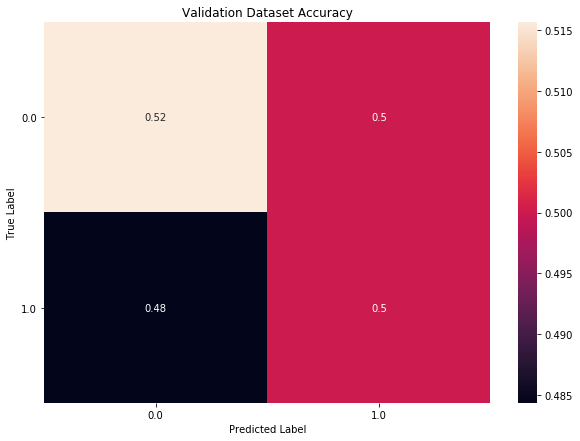

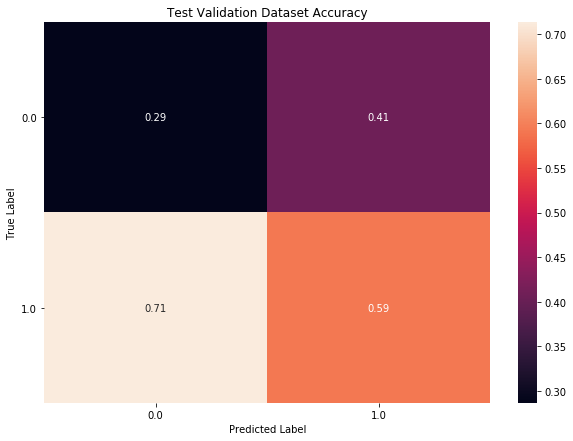

In [7]:
max_epochs = 2000
n_random_search = 1

batch_size = [128]
n_layers = [1] 
cnn_dropout_p = [None, 0.2, 0.5]
dense_dropout_p = [None, 0.2, 0.5]
activation = ['tanh']
n_dense_layers = [1,2,3]
n_dense_neurons = [100]
batch_normalization = [True]
optimizer = [Adam(learning_rate=0.005, clipvalue=0.5)]
#optimizer = [SGD(0.001)]

model_gs_params = list(itertools.product(*[n_layers, cnn_dropout_p, dense_dropout_p, activation, n_dense_layers, n_dense_neurons, batch_normalization, batch_size, optimizer]))
model_randomgs_params = random.sample(model_gs_params, n_random_search) if len(model_gs_params) > n_random_search else model_gs_params
print("%s Hyperparameter combinations determined" % len(model_randomgs_params))

training = PerformTraining(max_epochs, TRAIN_DATA_PATH, INTERM_DIR, MODEL_DIR,
                           model_randomgs_params, 'tcn', flush=True, save_plot=True)

# LSTM

In [5]:
max_epochs = 500
n_random_search = 1

n_layers = [2]
batch_size = [32]
lstm_neurons = [100, 500, 1000]
n_dense_neurons = [100, 500, 1000]
dropout = [None, 0.2, 0.5, 0.8]
optimizer = [Adam(learning_rate=0.01, clipvalue=0.5)]
#optimizer = [SGD(learning_rate=0.01)]

model_gs_params = list(itertools.product(*[n_layers, batch_size, lstm_neurons, n_dense_neurons, dropout, optimizer]))
model_randomgs_params = random.sample(model_gs_params, n_random_search) if len(model_gs_params) > n_random_search else model_gs_params
print("%s Hyperparameter combinations determined" % len(model_randomgs_params))

training = PerformTraining(max_epochs, TRAIN_DATA_PATH, INTERM_DIR, MODEL_DIR,
                           model_randomgs_params, 'lstm', flush=True, save_plot=True)

1 Hyperparameter combinations determined
The class distributions in the training set are: (array([0., 1.]), array([508, 622]))
The class distributions in the validation set are: (array([0., 1.]), array([113, 206]))
The class distributions in the test set are: (array([0., 1.]), array([80, 80]))
Presenting Results for: 1/1 Hyperparameter Combination
{'n_layers': 2, 'batch_size': 32, 'lstm_neurons': 500, 'n_dense_neurons': 1000, 'dropout': None, 'optimizer': <keras.optimizer_v2.adam.Adam object at 0x7efd0cd56bd0>}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (32, 31, 500)             1018000   
_________________________________________________________________
lstm_1 (LSTM)                (32, 500)                 2002000   
_________________________________________________________________
dense_3 (Dense)              (32, 1000)                501000    
_

KeyboardInterrupt: 